#338 Cups of Coffee

# Introduction
July 13th was a slow day at work. My primary intern project was on hold until somebody higher up in the food chain granted me access to a tool I needed and I had recently completed a few less-important tasks; it was one of those transition periods where you haven't quite decided what to do next. My response to this was the same as always; I closed my laptop and poured myself a cold brew. Mid-pour, I began to realize just how mindlessly I had ended up in my current state. I didn't really need to get a coffee, it just felt like the next thing to do. I began to question how often my coffee consumption was equally mindless as it had been in that moment. So I did what any good data nerd would do: I started a spreadsheet. 

From that day forward, each and every coffee, cold brew, hot or iced espresso beverage I have consumed has been logged on that spreadsheet. On this sheet I record the time I began drinking the coffee, when I woke up that day, whether I was stressed when I poured it, and what my mood was before and after drinking it. I wasn't quite sure what my end-goal was with this, but the more observations logged on this spreadsheet, the more interested I became in what exact patterns and relationships would emerge. 

Today, I have data on the last 338 cups of coffee I have consumed, over the course of 156 days. This spreadsheet, now a familiar fixture on the bookmark bar of my web browser and an integral part of my daily coffee consuming routines, has become a treasure-trove of data on my day-to-day life. Through this information I can track not only my caffeine consumption patterns, but my working and studying habits, my stress patterns, how well I've been sleeping lately, and in general when I'm most active throughout the day. In this analysis I will export this data to a CSV format and finally take a deep dive into the information it holds. My tools of choice for this will by Python, NumPy, Pandas, and Matplotlib. 

**For a general outline of this experiment, I will:**
* Read and clean the data
* Perform feature engineering to extract additional meaning from the features given
* Calculate summary statistics on coffee consumption, sleep habits, etc.
* Test the impact of coffee on my mood
* Examine my consumption patterns by time of day
* Conduct a time series analysis of my consumption patterns over time

In [796]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

# First, the ugly stuff
This data requires some preprocessing before we can do anything useful with it. Here I:
* Read the CSV into a Pandas DataFrame
* Print the columns to see what we have
* Select only the columns that have meaning
* Give the columns names that will be nicer to work with

In [797]:
coffee = pd.read_csv('20161216coffee.csv')
print coffee.columns

Index([u'CoffeeId', u'Person', u'Date', u'Date2', u'Time', u'Time2',
       u'datetime', u'Day of Week', u'Plain', u'Iced', u'Hot Espresso',
       u'Cold Espresso', u'Wakeup_time', u'Sleep_time',
       u'Stressed (binary yes or no)', u'Work/first class start time?',
       u'First, second, n_th coffee of the day? ',
       u'Pre-coffee mood (0 to 10, 5 is average)',
       u'post or current-coffee mood (0 to 10, 5 is average)', u'Hours sleep',
       u'Hours sleep 2', u'Units of Caffeine', u'Cumulative daily caffeine',
       u'Coffee', u'WeekNum', u'Comments?'],
      dtype='object')


In [798]:
cols = ['CoffeeId', 'Date', 'Time', 'datetime', 'Day of Week', 'Plain', 'Iced', 'Hot Espresso', \
       'Cold Espresso', 'Wakeup_time', 'Stressed (binary yes or no)', 'Work/first class start time?',\
       'First, second, n_th coffee of the day? ', 'Pre-coffee mood (0 to 10, 5 is average)', 'post or current-coffee mood (0 to 10, 5 is average)',\
       'Hours sleep', 'Units of Caffeine', 'Cumulative daily caffeine', 'Coffee', 'WeekNum']
coffee = coffee[cols]
coffee.columns = ['ID','Date','Time','Datetime','DOW','Plain','Iced', 'Hot_espresso','Cold_espresso','Wake_time',\
                  'Stressed','Work_time', 'Num_today_so_far', 'Pre_mood','Post_mood','Hours_sleep', \
                  'Units_caffeine', 'Cumulative_caff_day','Coffee','Week']

# Reformatting date and time features
Date and time features from Google Sheets are by default read in as strings. we need to change this to be able to calculate time differences, view trends over time, and have these sort nicely. Here, I:
* Reformat Date, Time, and Work/Class time into proper Date and Time types
* Create a Datetime column for viewing this as a time series
* Turn Hours Sleep into a timedelta type in order to get my bedtime from this feature and my wakeup time
* Get day of week and month of year, and week of year from the datetime value, allowing aggregation at different levels of precision

Note: Work_time has NaT in days where I had no work / class. This may need to be filtered later.

In [799]:
#Datetime
coffee['Datetime'] = coffee['Date'] + ' ' +  coffee['Time']
coffee['Datetime'] = pd.to_datetime(coffee['Datetime'], format='%m/%d/%Y %I:%M:%S %p')
coffee['Date'] = pd.to_datetime(coffee['Date'], format='%m/%d/%Y')

In [800]:
#more granular date / time features
coffee['Year'] = 2016
coffee['Month'] = coffee['Datetime'].dt.month
coffee['Day'] = coffee['Datetime'].dt.day
coffee['Hour'] = coffee['Datetime'].dt.hour
coffee['Minute'] = coffee['Datetime'].dt.minute

In [801]:
#work / class time and wakeup time to datetime.
coffee['Wake_time'] = coffee['Year'].astype(str) + "-" + coffee['Month'].astype(str) + "-" \
                    + coffee['Day'].astype(str) + " " + coffee['Wake_time']
coffee['Wake_time'] = pd.to_datetime(coffee['Wake_time'], format='%Y-%m-%d %I:%M %p')

coffee['Work_time'] = coffee['Year'].astype(str) + "-" + coffee['Month'].astype(str) + "-" \
                    + coffee['Day'].astype(str) + " " + coffee['Work_time']
coffee['Work_time'] = pd.to_datetime(coffee['Work_time'], format='%Y-%m-%d %I:%M %p')

In [802]:
#Hours sleep to timedelta. Get sleep time from hours sleep and wakeup time
coffee['Hours_sleep'] = pd.to_timedelta(coffee['Hours_sleep'], unit='h')
coffee['Bed_time'] = coffee['Wake_time'] - coffee['Hours_sleep']
coffee['Mood_change'] = coffee['Post_mood'] - coffee['Pre_mood']

** A look at the cleaned data: **

This takes up a considerable amount of space. Uncomment and run the line below to see the first few rows of the data if you are interested.

In [803]:
#print coffee.head()

# Summary Stats
Let's take a look at this from a birdseye view. In addition to the traditional set of summary statistics, it would be interesting to see: 
* How long I take, on average, from waking up to drinking my first cup
* A correlation matrix between the features, to see which ones might be related

###___Summary Table___

A few interesting things appear in the summary stats. First, it is clear that I drink far more plain and iced coffee than I do espresso beverages, with the means of my non-espresso beverages showing that approximately 84% of my consumption is non-espresso. Next, my average post-coffee mood is 0.3 points higher than my average pre-coffee mood. This is not statistically significant, but it does reflect a pattern in the direction that one would expect from a regular consumer. Some of these stats should be taken with caution. Hours Sleep, for example, is not on a per-day basis, but rather on a per-coffee basis. If I consume three coffees in a day, for example, the observation recorded with each cup of coffee will have its own Hours_Sleep value attached. To get my true average nightly sleep, we first need to collapse it to be one observation per day, which I will do below. 

In [804]:
print 'Summary stats from 7/13 to 12/16:' + '\n'
coffee[['Plain', 'Iced', 'Hot_espresso', 'Cold_espresso', 'Stressed', 'Pre_mood', 'Post_mood', \
                               'Mood_change', 'Hours_sleep', 'Units_caffeine']].describe()

Summary stats from 7/13 to 12/16:



,Plain,Iced,Hot_espresso,Cold_espresso,Stressed,Pre_mood,Post_mood,Mood_change,Hours_sleep,Units_caffeine
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338,338.000000
mean,0.488166,0.369822,0.127219,0.014793,0.266272,4.937870,5.298817,0.360947,0 days 06:53:36.568047,1.189349
std,0.500601,0.483472,0.333712,0.120902,0.442664,0.967875,0.978735,0.774145,0 days 01:34:53.081651,0.414434
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,-2.000000,0 days 01:00:00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0 days 06:00:00,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0 days 07:00:00,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,6.000000,1.000000,0 days 08:00:00,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,8.000000,3.000000,0 days 10:00:00,3.000000


### Box Plots
**Box plots** provide a nice visual display of how my consumption differs by coffee type. These plots display the inner quartile range (the box), median (the red line), and minimum and maximum values observed (the whiskers) for each category of coffee, summed by week. Iced and regular hot coffee were similar, with plain being the favorite. Hot espresso saw regular consumption, while clearly less than plain hot and iced coffee. Iced espresso drinks saw almost no consumption at all, never seeing more than one observation in a week.   

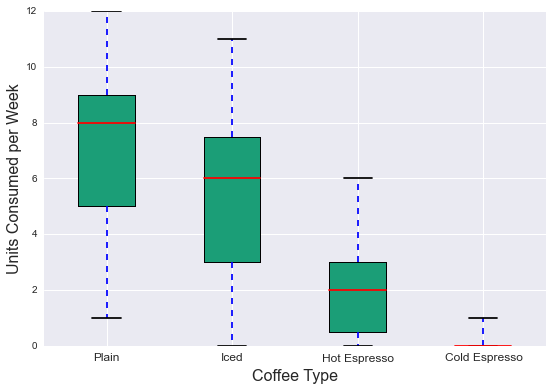

In [805]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
week_df = coffee.groupby('Week').sum().reset_index()
bp = ax.boxplot([week_df['Plain'],week_df['Iced'],week_df['Hot_espresso'],week_df['Cold_espresso']], patch_artist=True)
xtickNames = plt.setp(ax, xticklabels=['Plain', 'Iced', 'Hot Espresso', 'Cold Espresso'])
plt.setp(xtickNames, fontsize=12)
ax.set_ylabel('Units Consumed per Week', fontsize=16)
ax.set_xlabel('Coffee Type', fontsize=16)
[i.set(facecolor = '#1b9e77') for i in bp['boxes']];

###Cumulative Caffeine Intake by Category from 7/13 to 12/16 (156 Days)

Reinforcing the above point, I drank 165 units of caffeine from plain hot coffee, 125 from iced coffee, 43 from hot espresso, and only 5 from cold espresso. This amounts to **an average of 2.66 units of caffeine per day**. A **unit of caffeine in this analysis is loosely defined as an espresso shot's worth of caffeine**. This means that a standard cup of coffee is equivalent to one small latte, and that a medium latte is typically worth twice as much as a small one. 

In [806]:
print '\n' + 'Sums from 7/13 to 12/16:' + '\n'
print coffee[['Plain', 'Iced', 'Hot_espresso', 'Cold_espresso', 'Units_caffeine']].sum()


Sums from 7/13 to 12/16:

Plain             165
Iced              125
Hot_espresso       43
Cold_espresso       5
Units_caffeine    402
dtype: int64


In [807]:
avg_caffeine_per_day = np.mean(coffee.groupby('Date').sum()['Units_caffeine'])
print "Consumed " + str(avg_caffeine_per_day) + " units of caffeine per day on average."

Consumed 2.66225165563 units of caffeine per day on average.


# Impact on Mood
Next I want to see if coffee impacts how I feel. Throughout the study I recorded how I felt before and after drinking ocffee on a 10-point scale, with a 5 being average. Here I run a t-test to test whether the difference between
the columns for pre and post-coffee mood is statistically different from zero. A t-stat higher than 1.96 makes 
the findings statistically significant by common standards. Here, my t-stat is significantly larger than 1.96 in 
magnitude at a value of -4.82, making the mood change **statistically significant at the 99.99% confidence level**. This means that I can say with a high level of confidence that coffee improves my mood.

For the visual thinkers, I show box plots of these two columns as well. Their medians are the same (5, an "average"
mood), but the after-coffee column is skewed noticably higher than the before-coffee column. **My mood, on average, improved by 0.36 points on this 10-point scale**.


*This significant difference could be because of a legitimate positive impact of coffee on my mood (i.e. because I enjoy it, because of its relieving-effect on my caffeine addiction, or a combination of the two), but it could also reflect a bias in my own measurement system. There's really no way to test whether I was unbiased in my reporting, but it is worth noting this possibility.*

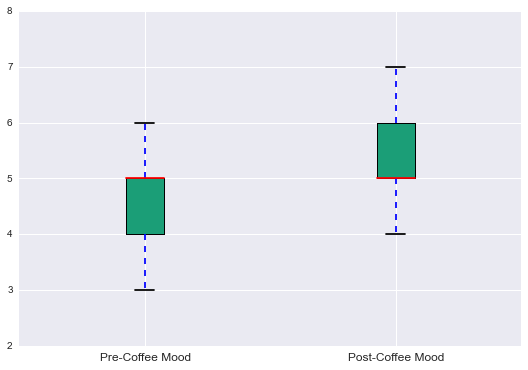

In [808]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([coffee['Pre_mood'],coffee['Post_mood']], patch_artist=True)
xtickNames = plt.setp(ax, xticklabels=['Pre-Coffee Mood', 'Post-Coffee Mood'])
plt.setp(xtickNames, fontsize=12)
[i.set(facecolor = '#1b9e77') for i in bp['boxes']];
plt.show()
t_val = scipy.stats.ttest_ind(coffee['Pre_mood'],coffee['Post_mood'])

In [809]:
print "T-value: " + str(t_val[0])
print "P-value: " + str(t_val[1])
print "\nmood improved by an average of " + str(np.mean(coffee['Mood_change'])) + " points after drinking coffee"\
", which was highly\nstatistically significant"

T-value: -4.82093137374
P-value: 1.76728456723e-06

mood improved by an average of 0.360946745562 points after drinking coffee, which was highly
statistically significant


# Hours Sleep and Time to First Coffee

**For this next step** I create a new data frame that contains only the first row for each day. This is required to analyze how long I take between waking up and having my first coffee each day. I exclude rows where the time is earlier than 3am, since these late night coffees rather than early-morning ones. Coincidentally, this also puts the data into a convenient shape for analyzing my sleep patterns, so I will begin to do that in this stage as well.

Over the 156 day period for which I have data, I spent a total of 44 days and 15 hours asleep, getting **roughly 7 hours of sleep per night. I spent just under an hour and 45 minutes between waking up and drinking my first daily coffee on average**. 

In [810]:
temp_df = coffee[coffee['Hour']>2].groupby('Date').first()
temp_df['Time_to_first_coffee'] = temp_df['Datetime'] - temp_df['Wake_time']  
print "Total time spent sleeping: " + str(np.sum(temp_df[['Hours_sleep']]['Hours_sleep']))
print "Average sleep per night: " + str(np.mean(temp_df[['Hours_sleep']]['Hours_sleep']))
print "Average time between waking up and drinking coffee: " + str(np.mean(temp_df[['Time_to_first_coffee']]['Time_to_first_coffee']))

Total time spent sleeping: 44 days 15:15:00
Average sleep per night: 0 days 07:08:30
Average time between waking up and drinking coffee: 0 days 01:39:26.400000


###Viewing how my time to first coffee has changed over time, we see that I go longer between waking up and drinking coffee at work than I do in school. 
This can be seen in the __drop occuring around September__, when I left work and began classes. This makes sense, since I have a coffee machine in my dorm at school, but had to wait until I arrived at work to drink coffee during the summer. 

**My median time-to-first-coffee was 40 minutes lower in school than it was during my summer internship.**

Mean time to coffee while working: 0 days 01:59:40.851063
Mean time to coffee while in school: 0 days 01:30:12.233009

Median time to coffee while working: 0 days 01:40:00
Median time to coffee while in school: 0 days 01:00:00


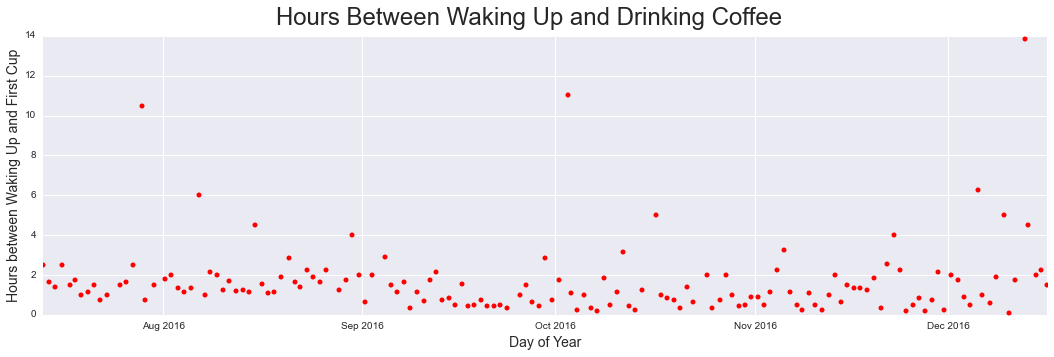

In [811]:
#label these axes

#use pre and post work dataframes to get mean during each of these periods. 
work_ttc = np.mean(temp_df[temp_df['Month']<9]['Time_to_first_coffee'])
work_ttc2 = np.median(temp_df[temp_df['Month']<9]['Time_to_first_coffee'])
school_ttc = np.mean(temp_df[temp_df['Month']>=9]['Time_to_first_coffee'])
school_ttc2 = np.median(temp_df[temp_df['Month']>=9]['Time_to_first_coffee'])
temp_df['Time_to_first_coffee'] = temp_df['Time_to_first_coffee']/ np.timedelta64(1, 'h') #conver to num. hours
fig = plt.figure(figsize=(18,5))
plt.plot_date(x=temp_df['Datetime'], y=temp_df['Time_to_first_coffee'], markersize=5, color='Red');
plt.xlabel('Day of Year', fontsize=14);
plt.ylabel('Hours between Waking Up and First Cup', fontsize=14);
plt.suptitle("Hours Between Waking Up and Drinking Coffee", fontsize=24)

print "Mean time to coffee while working: " + str(work_ttc)
print "Mean time to coffee while in school: " + str(school_ttc)
print "\nMedian time to coffee while working: " + str(pd.to_timedelta(work_ttc2))
print "Median time to coffee while in school: " + str(pd.to_timedelta(school_ttc2))

#Correlation Matrix
Next, let's look at how these features correlate with one another. The graphic below is a matrix of each feature's **Pearson correlation** with every other feature used in the analysis. Pearson correlation is a measure of the extent to which two features move together in a linear fashion. A highly positive (red) correlation means that those two features move closely in the same direction, and a highly negative (blue) correlation means that they move sharply in opposite directions. 

__**Some general takeaways from this**__: I tend to be in a better mood when I drink iced coffee than plain. This could be because I enjoy it more, but it could also be because it tends to be available to me in times and places where I am less overworked. Most of my late-night work sessions are fueled by plain coffee, for example, which can be seen in the positive correlation of plain coffee with stress, and the negative correlation between plain coffee and my mood. Iced coffee is typically only available to me in the mornings and afternoons, far-removed from any pre-deadline panic. 


**A few other things coming from this chart:**
* I got more sleep as the year went on (positive correlation between week, month, and hours slept)
* I drink less coffee when well-rested
* I became more stressed as the year went on (i.e. as midterms and finals week approached)
* I drink more coffee when I'm stressed

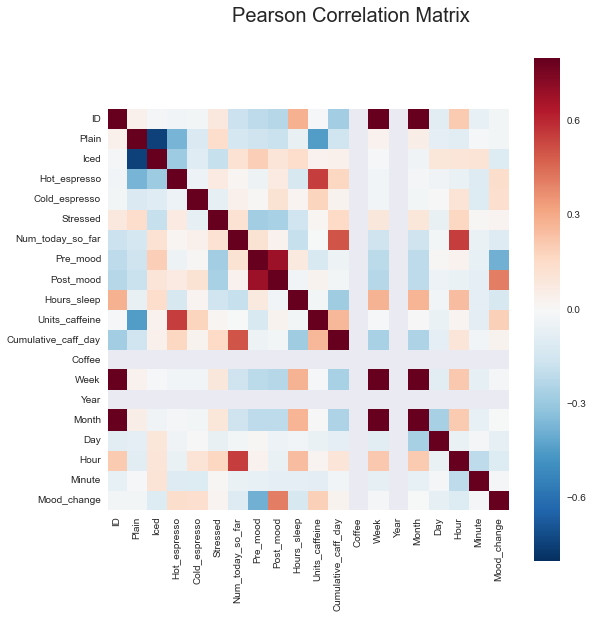

In [812]:
coffee['Hours_sleep'] = coffee['Hours_sleep']/ np.timedelta64(1, 'h')
corrmat = coffee.corr()
fig, ax = plt.subplots(figsize=(9,9)) 
plt.suptitle('Pearson Correlation Matrix', fontsize=20)
sns.heatmap(corrmat, vmax=.8, square=True);

# Trend Analysis
Next let's see how my coffee habits change over time, both throughout the day and across multiple days. 

###Consumption by Hour-of-Day and Category
These next three charts show my **aggregate coffee consumption, by category, broken down by hour of day**. The far-left chart is this pattern observed over the duration of the study (July - December), the middle one was that observed during my summer internship (up until September), and the far-right one is that observed during the fall semester of school (September - December). Pay little attention to the Y-axes on these plots, as the data here is aggregated over different-sized time periods between the graphs. These are solely useful for comparison in relative terms.

A few general takeaways:
* I tend to begin my day with plain hot coffee and move toward iced coffee in the late morning / early afternoon
* I drink my first coffee almost immediately upon beginning my day (right before class, or right when work starts)
* There is a "lunchtime drop" in the data during the internship around noon, where I hardly drink any coffee
* The pattern is bi-modal during the school year, likely because of the split M/W/F vs. T/Th nature of college class schedules
* I drink significantly more nighttime coffee in school than I did during the internship
* Iced espresso is a sad excuse for a caffeinated beverage, which I basically never consume ever

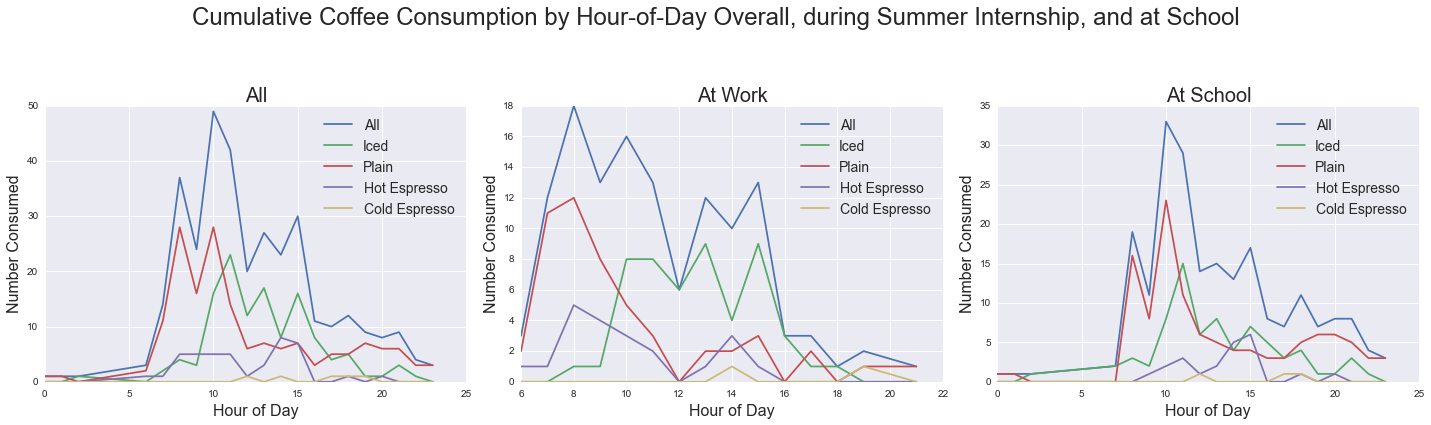

In [813]:
# pattern by hour of day. All vs. each individual class of coffee
def plot(ax, hour_df, title):
    ax.plot(hour_df['Hour'],hour_df['Coffee'], label='All')
    ax.plot(hour_df['Hour'],hour_df['Iced'], label="Iced")
    ax.plot(hour_df['Hour'],hour_df['Plain'], label='Plain')
    ax.plot(hour_df['Hour'],hour_df['Hot_espresso'], label='Hot Espresso')
    ax.plot(hour_df['Hour'],hour_df['Cold_espresso'], label="Cold Espresso")
    ax.legend(fontsize=14)
    ax.set_xlabel('Hour of Day', fontsize=16)
    ax.set_ylabel('Number Consumed', fontsize=16)
    ax.set_title(title, fontsize=20)

dfs = [coffee.groupby('Hour').sum().reset_index(), \
       coffee[coffee['Month']<9].groupby('Hour').sum().reset_index(),\
       coffee[coffee['Month']>=9].groupby('Hour').sum().reset_index()]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Cumulative Coffee Consumption by Hour-of-Day Overall, during Summer Internship, and at School', fontsize=24)
plot(ax1, dfs[0], "All")
plot(ax2, dfs[1], "At Work")
plot(ax3, dfs[2], "At School")
plt.tight_layout()
plt.subplots_adjust(top=0.75)

### Time Series: Weekly Consumption Levels (July - December 2016)
A few events show up when plotting each category of coffee's consumption from the beginning of this experiment to its end. **Around week 43** you can see a noticable spike in iced coffee consumption; this is around when I purchased my cold brew machine. Later, in **week 50**, you can see a spike in plain coffee; this is when I installed a Keurig in the lab where I do the majority of my school work. It also appears that the purchase of the cold brew machine also caused plain hot coffee to be displaced as my primary caffeine source from weeks 46 through 49. It will be interesting to see if this pattern continues in spring semester. 

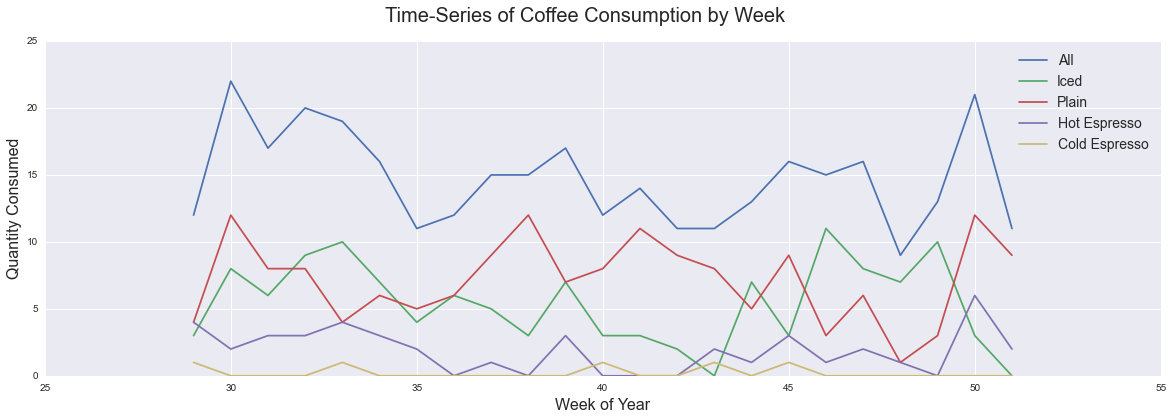

In [814]:
# collapse by week and show a running time series of each category (ie if the ratio changed in an intersting way)
plt.figure(figsize=(20,6));
plt.plot(week_df['Week'],week_df['Coffee'], label='All')
plt.plot(week_df['Week'],week_df['Iced'], label="Iced")
plt.plot(week_df['Week'],week_df['Plain'], label='Plain')
plt.plot(week_df['Week'],week_df['Hot_espresso'], label='Hot Espresso')
plt.plot(week_df['Week'],week_df['Cold_espresso'], label="Cold Espresso")
plt.suptitle('Time-Series of Coffee Consumption by Week', fontsize=20)
plt.xlabel('Week of Year', fontsize=16);
plt.ylabel('Quantity Consumed', fontsize=16);
plt.legend(fontsize=14);

## Other time series plots: caffeine intake, hours sleep, and wake-up time

###Caffeine Intake:
This metric became more volatile in school compared to at work. I also appear to consume slightly less in school. This is a very noisy pattern, however. 

###Hours Sleep:
Again, this metric is also considerably more volatile in school than it is while working. It roughly followed a quadratic pattern, where I got a low amount of sleep in the beginning and end of the experiment (at work and during the final exam period), but got significantly more sleep during the rest of the semester.

### Wake-Up Time
This chart makes it clear that I wake up later in school than I do while working. I wake up between 6 and 7 while working, while typically waking up between 7 and 10 during the semester. 


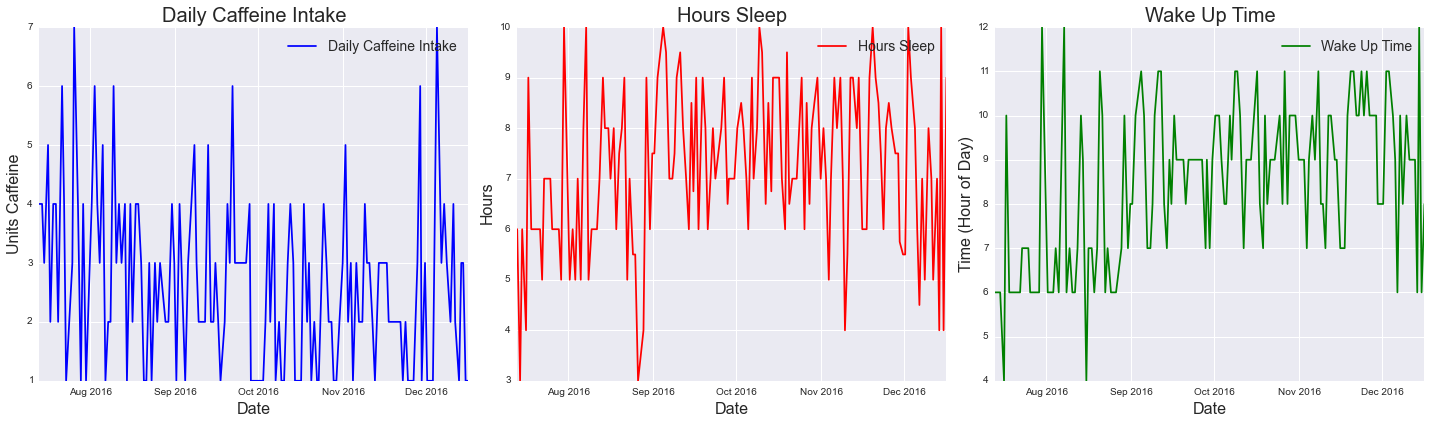

In [815]:
maxes = coffee.groupby('Date').last()
maxes['Wake_hour'] = maxes['Wake_time'].dt.hour

def plot(ax, var, label, ylab, color):
    ax.plot(maxes['Datetime'],maxes[var], label=label, color=color)
    ax.legend(fontsize=14)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.set_title(label, fontsize=20)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
plot(ax1, 'Cumulative_caff_day', "Daily Caffeine Intake", 'Units Caffeine', 'blue')
plot(ax2, 'Hours_sleep', "Hours Sleep", 'Hours', 'red')
plot(ax3, 'Wake_hour', 'Wake Up Time', 'Time (Hour of Day)', 'green')

plt.tight_layout()

### Hours Sleep Histogram
My hours sleep was bi-modal as expected, due to the differing M/W/F and T/Th schedules I have during the semester. I tend to get six to seven hours sleep before my T/Th classes, where my first class is at 9am, and also on work days, while getting eight to nine hours sleep on my M/W/F class schedule, where my first class is not until 2pm. 

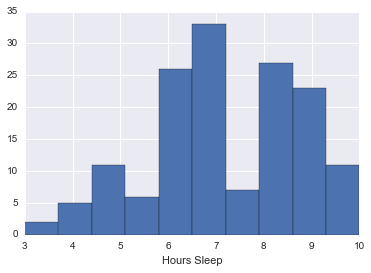

In [816]:
maxes['Hours_sleep'].hist().set_xlabel('Hours Sleep');

# Breakdown by Day of Week
Last, viewing the number of caffeinated beverages I consume by day of week at school vs. at work sheds some light on both my working and caffeination patterns. 

**During a work week** my caffeination is more or less stable Monday through Friday. I am a creature of habit on these days. I drink my morning coffee upon arriving to the office, a cold brew coffee an hour or so after that, and then one or two more after lunch to end the evening. I do not drink any more once I'm home, and on the weekend I will have one or two coffees while doing work at a Philz or Starbucks.

**During school** my life is less stable and pattern-driven. My caffeine consumption depends on my class schedule and workload each day, and it is not bounded by a set 9-5 work day. I tend to work (and concequently drink the least coffee) on Fridays and Saturdays, since these are the days it is easiest to relax and not work as a student. My Sundays are roughly the equivalent of a weekday with the preparation that is needed for the week, and this is reflected in the amount of coffee I drink. My weeks, in general, are much more front-loaded in terms of both workload and coffee consumption while in school.

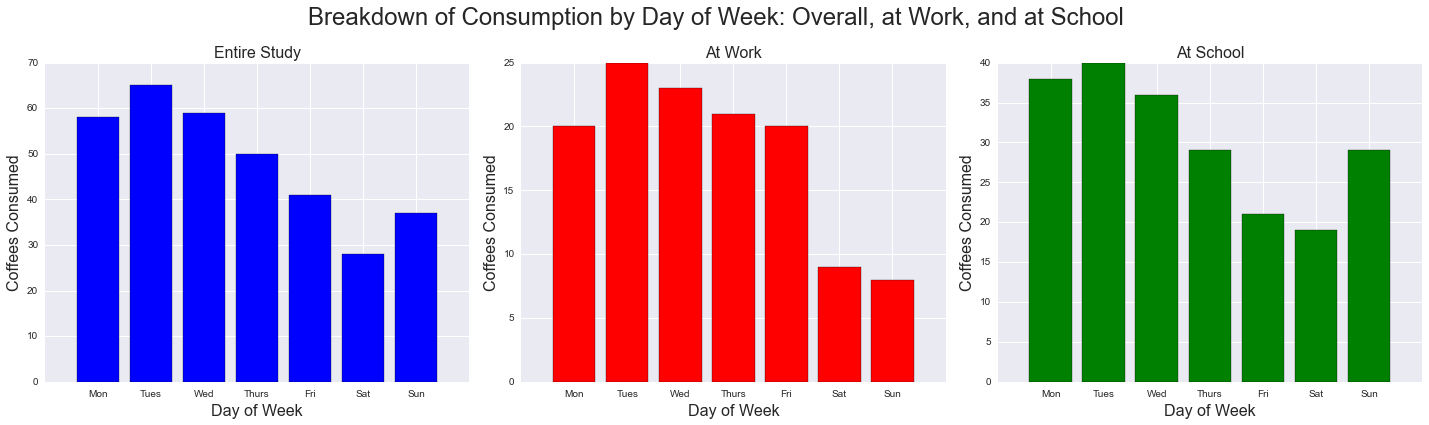

In [817]:
coffee['DOW_numerical'] = coffee['Datetime'].dt.dayofweek

def plot(ax, df, title, color):
    ax.bar([0,1,2,3,4,5,6], df.groupby('DOW_numerical').count().reset_index()['Coffee'],align='center', color=color)
    ax.set_xlim([-1, 6])
    #ax.set_xticks([0,1,2,3,4,5,6,7], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    ax.set_xlabel('Day of Week', fontsize=16)
    ax.set_ylabel('Coffees Consumed', fontsize=16)
    ax.set_title(title, fontsize=16)

dfs = [coffee, coffee[coffee['Month']<9],coffee[coffee['Month']>=9]]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle("Breakdown of Consumption by Day of Week: Overall, at Work, and at School", fontsize=24)
plot(ax1, dfs[0], "Entire Study", 'blue')
plot(ax2, dfs[1], "At Work", 'red')
plot(ax3, dfs[2], "At School", 'green')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.setp((ax1, ax2, ax3), xticks=[0,1,2,3,4,5,6,7], xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);

# Conclusions

I began this project last July with a broad question in mind; am I a creature of habit? Do I drink coffee out of a love for the beverage, or because I've wired myself to depend on it? Additional to these questions, I had a general curiosity for how much of my life I could model by simply tracking the consumption of this one type of drink. 

In general, these results show that I am, indeed, a creature of habit. My coffee patterns vary very little day-to-day, having clear "peak" times in which I almost always have a cup. My coffee patterns almost identically follow my working patterns. 

This data also lends support to my hypothesis of a caffeine dependency. Both the stable consumption patterns and the statistically significant mood change associated with caffeine intake make this difficult to refute. This is also supported by the fact that I care enough about this beverage to have tracked its consumption in a spreadsheet for the past 150+ days, because that's a completely normal thing to do.

An added bonus to this experiment was the light it shed on my sleeping patterns, since I did not even realize that these were hidden in the data until midway through my data collection. I now know how long I go between waking up and drinking my morning coffee, the relationship between coffee and how long I slept the previous night, and how well or poorly I sleep under various conditions. 

# Next Steps
I have continued logging my coffees since concluding this analysis, and am ansure as to when I'll stop. It may be tomorrow, it may be next year (I would be really interested in seeing this after an entire year of data had been logged). Regardless, I will not likely be adding much new to this spreadsheet as far as features go. 

A few additional things that would be interesting to analyze here are: 
* These same patterns with weekends removed (this would likely smooth over many of the curves we see)
* Relationship between coffee consumption and "big events" such as exams and presentations
* Turning this into something more interactive or actionable, such as a recommender system or dashboard